In [2]:
import os
import zipfile
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix


In [4]:
pip install "numpy<2"


Note: you may need to restart the kernel to use updated packages.


In [6]:

# Extract dataset if still in ZIP format
zip_path = "C:\\Users\\K.Meghana\\Desktop\\archive (2).zip"
extract_dir = "ravdess"

if not os.path.exists(extract_dir):  # Extract only if not already extracted
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_dir)


In [8]:
# Load dataset (RAVDESS)
audio_files = []
labels = []

In [10]:
# RAVDESS naming convention: '03-01-06-02-02-01-12.wav' (emotion class is the third number)
for folder in os.listdir(extract_dir):
    folder_path = os.path.join(extract_dir, folder)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            if file.endswith(".wav"):
                file_path = os.path.join(folder_path, file)
                if os.path.exists(file_path):  # Check if file exists
                    emotion = int(file.split("-")[2]) - 1  # Convert to zero-indexed
                    audio_files.append(file_path)
                    labels.append(emotion)


In [12]:
# Convert to DataFrame
df = pd.DataFrame({"file": audio_files, "emotion": labels})



In [14]:
# Feature extraction (MFCCs)
def extract_features(file_path, max_pad_len=100):
    try:
        audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        if pad_width > 0:
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfccs = mfccs[:, :max_pad_len]
        return mfccs
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return np.zeros((40, max_pad_len))

X = np.array([extract_features(file) for file in df['file']])
y = np.array(df['emotion'])


In [18]:
# Encode labels
encoder = LabelEncoder()
y = encoder.fit_transform(y)


In [20]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [22]:
# Reshape input for LSTM (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])


In [24]:
# Build LSTM model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(len(set(y)), activation='softmax')
])

C:\Users\K.Meghana\jupyter\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [26]:
# Compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [28]:
# Train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=32)



Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 103ms/step - accuracy: 0.1384 - loss: 2.0715 - val_accuracy: 0.1771 - val_loss: 2.0510
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.2809 - loss: 1.9593 - val_accuracy: 0.2431 - val_loss: 1.9904
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.3780 - loss: 1.8066 - val_accuracy: 0.2778 - val_loss: 1.8959
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.4724 - loss: 1.5706 - val_accuracy: 0.2917 - val_loss: 1.9030
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.5959 - loss: 1.2690 - val_accuracy: 0.3194 - val_loss: 1.8502
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.6445 - loss: 1.0560 - val_accuracy: 0.3333 - val_loss: 1.9012
Epoch 7/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.7360 - loss: 0.8343 - val_accuracy: 0.3438 - val_loss: 2.0934
Epoch 8/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.8053 - loss: 0.6537 - val_accuracy: 0.3438 -

In [30]:
# Evaluate model
y_pred = np.argmax(model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred))


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
              precision    recall  f1-score   support

           0       0.29      0.25      0.27        20
           1       0.43      0.52      0.47        44
           2       0.31      0.32      0.32        34
           3       0.22      0.21      0.21        39
           4       0.37      0.31      0.34        42
           5       0.27      0.47      0.34        32
           6       0.37      0.44      0.40        32
           7       0.50      0.20      0.29        45

    accuracy                           0.34       288
   macro avg       0.35      0.34      0.33       288
weighted avg       0.36      0.34      0.33       288



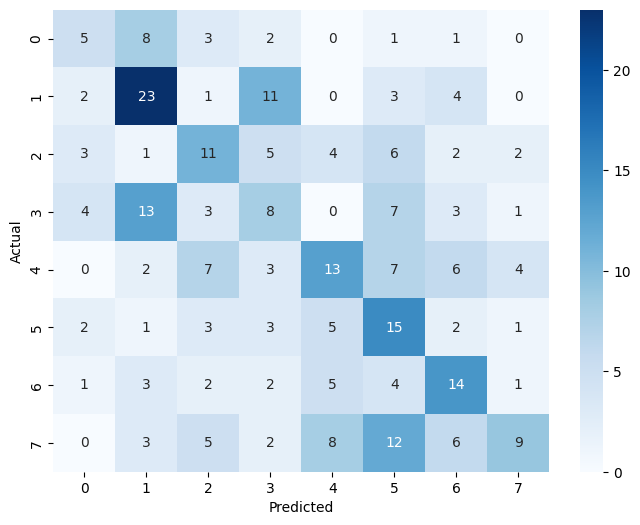

In [32]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()